# Synthetic Experiments using Stochastic Block Models

In [1]:
import pickle as pkl
from torch_geometric.loader import DataLoader
import networkx as nx

import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from src.utils.CreateFeatures import CreateFeatures
from src.pygcn.SiameseGNN import SiameseGNN
from torch_geometric.utils import to_networkx

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import f1_score

from torch_geometric.utils import to_networkx
import networkx as nx
import numpy as np
import itertools


from sklearn.model_selection import train_test_split
import os
import pickle
import json

from src.synthetic_experiments.sample import sample_pairs
from src.utils.misc import collate

In [2]:
def run_model(model, training_data_pairs, validation_data_pairs):
    torch.manual_seed(42)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.BCELoss()  # Changed to BCEWithLogitsLoss for numerical stability

    for epoch in tqdm(range(10)):
        model.train()
        train_losses = []
        for (graph1, graph2, labels) in training_data_pairs:
            optimizer.zero_grad()
            out = model(graph1, graph2)
    
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        scheduler.step()

        model.eval()
        with torch.no_grad():
            val_losses = []

            val_pred = []
            val_truth = []

            correct = 0
            total = 0
            for (graph1, graph2, labels) in validation_data_pairs:
                out = model(graph1, graph2)

                val_loss = criterion(out, labels)
                val_losses.append(val_loss.item())

                predictions = torch.round(out)

                val_pred.extend(predictions.cpu().numpy())
                val_truth.extend(labels.cpu().numpy())

                correct += (predictions == labels).sum().item()
                total += labels.size(0)

            val_loss = sum(val_losses) / len(val_losses)
            val_accuracy = correct / total

        val_f1 = f1_score(val_truth, val_pred)
        print(f'Epoch: {epoch+1}, Training Loss: {sum(train_losses)/len(train_losses)}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation F1 Score: {val_f1}')
    return val_accuracy, val_f1


## Clique Data

In [3]:
# Assuming root_dir is the path to your root directory
root_dir = 'results/synthetic/'

clique_data = {}
cp_times = {}
label_data = {}

# Walk through all directories and files in root_dir
for dirpath, dirnames, filenames in os.walk(root_dir):
    # If there's a data.p file in this directory, read it
    args_file = os.path.join(dirpath, 'args.json')
    if os.path.isfile(args_file):
        with open(args_file, 'rb') as f:
            arg_data = json.load(f)
            clique_size = arg_data['size_clique']

    data_file = os.path.join(dirpath, 'data.p')
    if os.path.isfile(data_file):
        with open(data_file, 'rb') as f:
            data = pickle.load(f)
            clique_data[clique_size] = data

    # If there's a time.json file in this directory, read it
    time_file = os.path.join(dirpath, 'time.json')
    if os.path.isfile(time_file):
        with open(time_file, 'r') as f:
            time_data = json.load(f)
            cp_times[clique_size] = time_data

    label_file = os.path.join(dirpath, 'labels.p')
    if os.path.isfile(label_file):
        with open(label_file, 'rb') as f:
            data = pickle.load(f)
            label_data[clique_size] = data

In [4]:
sizes = [20, 30, 40, 50, 60, 70, 80]

In [6]:
for s in [20]:
    for j, i in enumerate(clique_data[s]):
        edge_index = i.edge_index.to(torch.int64)
        networkx_graph = to_networkx(i)
        adjacency = nx.adjacency_matrix(networkx_graph)
        
        attributes = np.eye(adjacency.shape[0])
        clique_data[s][j].x = attributes
    
    train = clique_data[s][:1000]
    train_labels = label_data[s][:1000]

    val = clique_data[s][1000:2000]
    val_labels = label_data[s][1000:2000]

    test = clique_data[s][2000:]
    test_labels = label_data[s][2000:]

    graph_pairs_train = sample_pairs(train,train_labels,nsamples=3000)
    graph_pairs_val = sample_pairs(train,val_labels,nsamples=2000)

    input_dim = graph_pairs_train[0][0].x.shape[1]

    # Define hyperparameter grids
    learning_rates = [0.01]
    dropout_rates = [0.05]
    sort_k_values = [30]
    hidden_units_values = [64]

    # Create combinations of hyperparameters
    hyperparameter_combinations = list(itertools.product(learning_rates, dropout_rates, sort_k_values, hidden_units_values))

    for lr, dropout_rate, sort_k, hidden_units in hyperparameter_combinations:
        model = SiameseGNN(sort_k, input_dim, dropout = dropout_rate, nhidden=hidden_units)
        val_accuracy, val_f1 = run_model(model, graph_pairs_train, graph_pairs_val)

    model_name = f"models/sgnn-topk{sort_k}-64hidden-{s}clique.pt"
    torch.save(model.state_dict(), model_name)

    time_test = [t-2000 for t in cp_times[s] if t>=2000]
    time_train = [t for t in cp_times[s] if t<1000]

    with open(f'results/test_synthetic/test/{s}-data.p', 'wb') as f:
        pickle.dump(test, f)

    with open(f'results/test_synthetic/test/{s}-labels.p', 'wb') as f:
        pickle.dump(test_labels, f)

    with open(f'results/test_synthetic/test/{s}-time.json', 'w') as f:
        json.dump(time_test, f)

    #Dump validation data
    with open(f'results/test_synthetic/val/{s}-data.p', 'wb') as f:
        pickle.dump(train, f)

    with open(f'results/test_synthetic/val/{s}-labels.p', 'wb') as f:
        pickle.dump(train_labels, f)

    with open(f'results/test_synthetic/val/{s}-time.json', 'w') as f:
        json.dump(time_train, f)

1500 positive and 1500 negative examples
1000 positive and 1000 negative examples


 10%|█         | 1/10 [00:58<08:45, 58.41s/it]

Epoch: 1, Training Loss: 0.6673932578461597, Validation Loss: 0.6874624567638782, Validation Accuracy: 0.5655951346655083, Validation F1 Score: 0.0


 20%|██        | 2/10 [01:58<07:56, 59.57s/it]

Epoch: 2, Training Loss: 0.6652419877292527, Validation Loss: 0.6880813749405118, Validation Accuracy: 0.5655951346655083, Validation F1 Score: 0.0


 30%|███       | 3/10 [02:57<06:53, 59.07s/it]

Epoch: 3, Training Loss: 0.6632562540490321, Validation Loss: 0.686959660773066, Validation Accuracy: 0.5655951346655083, Validation F1 Score: 0.0


 40%|████      | 4/10 [03:55<05:52, 58.69s/it]

Epoch: 4, Training Loss: 0.6544776974081693, Validation Loss: 0.6901160970161937, Validation Accuracy: 0.5660295395308428, Validation F1 Score: 0.19500402900886382


 50%|█████     | 5/10 [04:54<04:53, 58.74s/it]

Epoch: 5, Training Loss: 0.6307369858964865, Validation Loss: 0.6976855047545569, Validation Accuracy: 0.5599478714161599, Validation F1 Score: 0.334865397242285


 60%|██████    | 6/10 [05:52<03:54, 58.61s/it]

Epoch: 6, Training Loss: 0.5980111077953346, Validation Loss: 0.715026348097805, Validation Accuracy: 0.5629887054735013, Validation F1 Score: 0.41100702576112413


 70%|███████   | 7/10 [06:51<02:56, 58.73s/it]

Epoch: 7, Training Loss: 0.5536204815567741, Validation Loss: 0.7489847431847781, Validation Accuracy: 0.5647263249348393, Validation F1 Score: 0.4560260586319218


 80%|████████  | 8/10 [07:50<01:57, 58.82s/it]

Epoch: 8, Training Loss: 0.5009066708911426, Validation Loss: 0.7703902568412438, Validation Accuracy: 0.5729800173761946, Validation F1 Score: 0.4288204532248693


 90%|█████████ | 9/10 [08:49<00:59, 59.01s/it]

Epoch: 9, Training Loss: 0.45224896120259384, Validation Loss: 0.8438316450642824, Validation Accuracy: 0.5682015638575152, Validation F1 Score: 0.48443983402489627


100%|██████████| 10/10 [09:47<00:00, 58.76s/it]

Epoch: 10, Training Loss: 0.405041564946586, Validation Loss: 0.9324713763849669, Validation Accuracy: 0.5742832319721981, Validation F1 Score: 0.4082125603864734


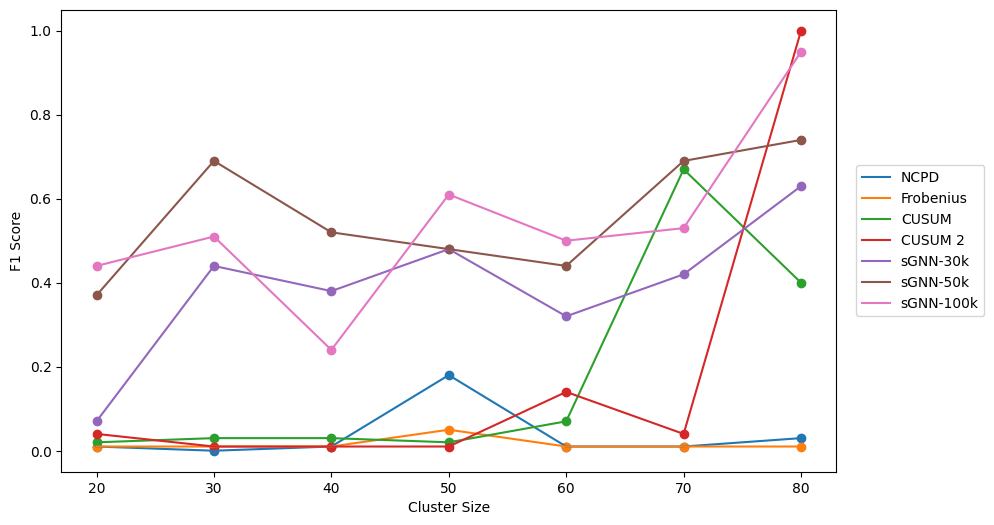

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Assuming these are your four lists
x = [20, 30, 40, 50, 60, 70, 80]
ncpd = [0.01, 0.00, 0.01, 0.18, 0.01, 0.01, 0.03]
frob = [0.01, 0.01, 0.01, 0.05, 0.01, 0.01, 0.01]
cusum = [0.02, 0.03, 0.03, 0.02, 0.07, 0.67, 0.40]
cusum_2 = [0.04, 0.01, 0.01, 0.01, 0.14, 0.04, 1.0]

sgnn_30 = [0.07, 0.44, 0.38, 0.48, 0.32, 0.42, 0.63]
sgnn_50 = [0.37, 0.69, 0.52, 0.48, 0.44, 0.69, 0.74]
sgnn_100 = [0.44, 0.51, 0.24, 0.61, 0.5, 0.53, 0.95]

# Create a line chart
plt.plot(x, ncpd, label='NCPD')
plt.plot(x, frob, label='Frobenius')
plt.plot(x, cusum, label='CUSUM')
plt.plot(x, cusum_2, label='CUSUM 2')
plt.plot(x, sgnn_30, label='sGNN-30k')
plt.plot(x, sgnn_50, label='sGNN-50k')
plt.plot(x, sgnn_100, label='sGNN-100k')

plt.scatter(x, ncpd)
plt.scatter(x, frob)
plt.scatter(x, cusum)
plt.scatter(x, cusum_2)
plt.scatter(x, sgnn_30)
plt.scatter(x, sgnn_50)
plt.scatter(x, sgnn_100)
# Add a legend
plt.legend(bbox_to_anchor=(1.20, 0.5), loc='center right')

plt.xlabel('Cluster Size')
plt.ylabel('F1 Score')
# Show the plot
plt.show()